# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import stats
import numpy as np

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

In [2]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()

cutoff = pd.Timestamp("2026-02-03 11:10:55.661533+00", tz="UTC")
df_raw = df_raw[pd.to_datetime(df_raw["created_at"], utc=True) >= cutoff]

display(df_raw)
print(df_raw.shape)

id              prolific_pid  \
24   67c36565-ecf2-4655-a5f6-d3e86b19dcc6  5dd2ccf12e6c772de06f525b   
25   cc408b35-1a37-439d-8e76-11ba7a596404  697a5d3fb0c089ca2e54958a   
26   53f4d379-699c-4a1b-9fdf-e177887c638f  5f3adfbf2e598b7a0b73c45e   
46   d39b2495-ab78-47d9-8ab6-55f7ac40ca2b  5e3ddcf95556b204cb143eab   
47   7fa24d31-ea02-4cd4-8b82-5afbfeb09072  6658b32dd8c3da854c842802   
..                                    ...                       ...   
240  2702223e-cd3a-48f4-b783-a9ccad6902a7  696abe3b7d7f518c6540fa45   
241  80a3704a-8168-440b-9d78-7bde71e801fa  604db6324496c57afe822770   
242  d6a5cde0-922f-4d55-866a-7d6dd3249c0d  665ee374604d2c5d4d858efd   
243  b48ecd00-c2c4-423c-ab8a-57e4a041b14e  5e8b9c7054a5cc07dd6e174d   
244  7e400388-e9d6-430d-a66e-6552af148100  607668ac450fc6e3025a131d   

           profile_id exit_reason                        created_at  \
24    profile_23_last   completed  2026-02-03T11:13:06.096269+00:00   
25   profile_33_first   completed  2026-02-03T11:13:13.411361+00:00   
26    profile_20_last   completed  2026-02-03T11:13:19.079171+00:00   
46    profile_29_last   completed  2026-02-03T11:13:27.843382+00:00   
47    profile_14_last   completed  2026-02-03T11:13:37.649977+00:00   
..                ...         ...                               ...   
240  profile_35_first   completed  2026-02-07T14:52:11.717503+00:00   
241   profile_18_last   completed  2026-02-07T14:54:16.791672+00:00   
242  profile_32_first   completed  2026-02-07T14:57:42.397018+00:00   
243   profile_33_last   completed  2026-02-07T15:11:34.542454+00:00   
244  profile_14_first   completed  2026-02-07T15:38:29.671297+00:00   

                                                  data      exit_time  \
24   [{'rt': 1722, 'study_id': '6962232f30c21461e6a...  1770117186247   
25   [{'rt': 23496, 'study_id': '6962232f30c21461e6...  1770117192502   
26   [{'rt': 5852, 'study_id': '6962232f30c21461e6a...  1770117197118   
46   [{'rt': 15900, 'study_id': '6962232f30c21461e6...  1770117207663   
47   [{'rt': 5467, 'study_id': '6962232f30c21461e6a...  1770117216893   
..                                                 ...            ...   
240  [{'rt': 20172, 'study_id': '6980c852b1ec006643...  1770475930203   
241  [{'rt': 8493, 'study_id': '6980c852b1ec006643f...  1770476056092   
242  [{'rt': 8443, 'study_id': '6980c852b1ec006643f...  1770476261089   
243  [{'rt': 12669, 'study_id': '6980c852b1ec006643...  1770477094161   
244  [{'rt': 17957, 'study_id': '6980c852b1ec006643...  1770478705922   

     experiment_start_time  profile_index  
24           1770116663290             31  
25           1770116696579             52  
26           1770116662731             25  
46           1770116680483             43  
47           1770116783947             11  
..                     ...            ...  
240          1770475194488             35  
241          1770475102273             20  
242          1770475460953             45  
243          1770476477662             46  
244          1770477198757             58  

[161 rows x 9 columns]

(161, 9)


In [3]:
df_extra = pd.DataFrame(rows)

# Drop all test and debug participants
df_extra = df_extra[(~df_extra['prolific_pid'].str.startswith('DEBUG')) &
    (~df_extra['prolific_pid'].str.startswith('TEST_'))
].copy()

start_cutoff = pd.Timestamp("2026-01-28 12:50:00+00:00", tz="UTC")
main_cutoff  = pd.Timestamp("2026-02-02 11:10:55.661533+00", tz="UTC")

df_extra["created_at"] = pd.to_datetime(df_extra["created_at"], utc=True)

df_extra = df_extra[
    (df_extra["created_at"] >= start_cutoff)
    & (df_extra["created_at"] <  main_cutoff)
]


display(df_extra)
print(df_extra.shape)

id              prolific_pid  \
73  9c0d06ee-31ab-4c79-9f29-60340eb12bc2  5997043dbbe84800017964a7   
74  cae0bb77-d57a-41ca-8dd0-f86f78a6d8da  5a381de00006450001bf2691   
75  5234326d-6ea1-49fb-93af-ee75e3984bec  676061b0d6e01e2e9548a4b9   
76  da575643-83eb-4e38-80ce-03c10cd672cd  5bf8a27021a4e1000194fc76   
77  22802372-74d0-411e-b879-ad9fdd2cf510  6146548679f86b7cb069e7f7   
78  8d8195d4-b457-4dc8-8759-55a0fd0bdd29  5c5cad3e4ee81200018eafe2   
79  1a28d289-0ebb-4d80-8695-5706704a0021  6053e01a6a8e8516ba7d47a7   
80  af0da243-8692-4325-8db2-4342e07029c7  571bdaa76b0894001362f780   
81  6950a956-3a7a-4d54-ada1-1895374aa902  676063838d4db0d3eaa69c2b   
82  7c24ad90-a9d6-44d4-80d1-ea16478e0096  61517db6a7589569521b2356   
83  81713bc6-8557-41cf-9159-fbc8a0d4dbd5  62c4590804317dc197ecbe8a   
84  657802d2-ca9b-4f75-a6e4-efa550fdc62f  5fb551ccab996500099ab1aa   

          profile_id        exit_reason                       created_at  \
73    profile_6_last  failed_distractor 2026-01-28 12:57:10.075912+00:00   
74   profile_17_last          completed 2026-01-28 13:01:09.976787+00:00   
75   profile_23_last          completed 2026-01-28 13:01:43.657952+00:00   
76    profile_2_last          completed 2026-01-28 13:06:27.084044+00:00   
77   profile_11_last          completed 2026-01-28 13:07:56.910077+00:00   
78   profile_33_last          completed 2026-01-28 13:08:39.759393+00:00   
79   profile_3_first          completed 2026-01-28 13:11:20.176687+00:00   
80   profile_7_first          completed 2026-01-28 13:15:48.124049+00:00   
81   profile_13_last          completed 2026-01-28 13:17:42.084933+00:00   
82  profile_35_first   failed_attention 2026-01-28 13:24:27.069578+00:00   
83   profile_34_last          completed 2026-01-28 13:44:46.830223+00:00   
84  profile_36_first          completed 2026-01-28 13:56:58.856554+00:00   

                                                 data      exit_time  \
73  [{'rt': 11700, 'study_id': '6962232f30c21461e6...  1769605029862   
74  [{'rt': 14626, 'study_id': '6962232f30c21461e6...  1769605269189   
75  [{'rt': 21763, 'study_id': '6962232f30c21461e6...  1769605302694   
76  [{'rt': 14676, 'study_id': '6962232f30c21461e6...  1769605586286   
77  [{'rt': 17468, 'study_id': '6962232f30c21461e6...  1769605676363   
78  [{'rt': 12588, 'study_id': '6962232f30c21461e6...  1769605719886   
79  [{'rt': 17185, 'study_id': '6962232f30c21461e6...  1769605879714   
80  [{'rt': 1575, 'study_id': '6962232f30c21461e6a...  1769606146541   
81  [{'rt': 1414, 'study_id': '6962232f30c21461e6a...  1769606181795   
82  [{'rt': 28624, 'study_id': '6962232f30c21461e6...  1769606665652   
83  [{'rt': 30602, 'study_id': '6962232f30c21461e6...  1769607885316   
84  [{'rt': 1580, 'study_id': '6962232f30c21461e6a...  1769608617037   

    experiment_start_time  profile_index  
73          1769604712731             67  
74          1769604706487             17  
75          1769604839827             31  
76          1769605024569             45  
77          1769604826317              5  
78          1769604862872             53  
79          1769604911837             60  
80          1769605546811             68  
81          1769605539794              9  
82          1769605461409             56  
83          1769607046363             55  
84          1769607687932             58

(12, 9)


In [4]:
profiles_raw = set(df_raw["profile_id"].dropna().astype(str))
profiles_extra = set(df_extra["profile_id"].dropna().astype(str))

overlap = profiles_raw & profiles_extra

print("Profiles in df_raw:", len(profiles_raw))
print("Profiles in df_extra:", len(profiles_extra))
print("Overlapping profiles:", len(overlap))


Profiles in df_raw: 69
Profiles in df_extra: 12
Overlapping profiles: 12


In [5]:
raw_counts = (
    df_raw["profile_id"]
    .value_counts()
    .rename("raw_count")
    .to_frame()
)
extra_profiles = set(df_extra["profile_id"].astype(str))

raw_counts["in_df_extra"] = raw_counts.index.isin(extra_profiles)


In [6]:
raw_counts.groupby("in_df_extra")["raw_count"].describe()


count      mean       std  min  25%  50%  75%  max
in_df_extra                                                    
False         57.0  2.280702  1.206447  1.0  1.0  2.0  3.0  5.0
True          12.0  2.583333  1.443376  1.0  1.0  2.5  4.0  5.0

In [149]:
df_raw = df_extra.copy()

<Figure size 640x480 with 0 Axes>

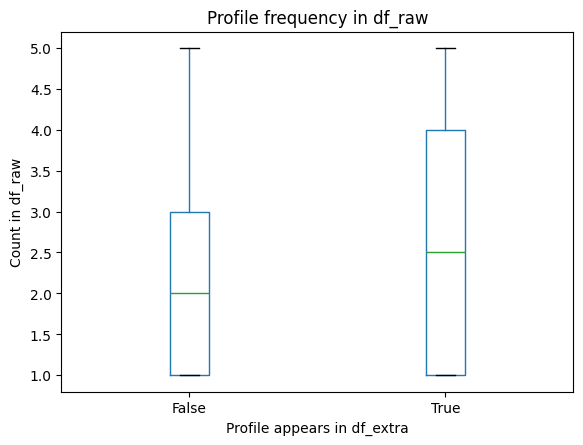

In [7]:
import matplotlib.pyplot as plt

plt.figure()
raw_counts.boxplot(
    column="raw_count",
    by="in_df_extra",
    grid=False
)
plt.suptitle("")
plt.title("Profile frequency in df_raw")
plt.xlabel("Profile appears in df_extra")
plt.ylabel("Count in df_raw")
plt.show()


In [150]:
resp = (
    supabase
    .table("profile_assignments")
    .select("profile_id, completed")
    .execute()
)

df_profiles = pd.DataFrame(resp.data)

remaining = df_profiles[df_profiles["completed"] == False]

print("Remaining profiles:", len(remaining))
display(remaining.sort_values("profile_id"))


Remaining profiles: 5


profile_id  completed
1   profile_15_last      False
63  profile_25_last      False
2   profile_2_first      False
62  profile_36_last      False
0    profile_9_last      False

In [151]:
# Explode df_raw into trial-level df 
rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    if profile_id.endswith("_first"):
        intro_position = "first"
    elif profile_id.endswith("_last"):
        intro_position = "last"
    else:
        intro_position = None

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
            "intro_position": intro_position,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)
df = df.dropna(axis=1, how="all")

display(df.head(10))
print("Shape:", df.shape)


PROLIFIC_PID       profile_id exit_reason intro_position  \
0  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
1  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
2  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
3  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
4  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
5  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
6  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
7  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
8  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   
9  5dd2ccf12e6c772de06f525b  profile_23_last   completed           last   

        rt                  study_id      exit_time  timed_out  \
0   1722.0  6962232f30c21461e6a14157  1770117186247       True   
1      NaN  6962232f30c21461e6a14157  1770117186247       True   
2      NaN  6962232f30c21461e6a14157  1770117186247       True   
3      NaN  6962232f30c21461e6a14157  1770117186247       True   
4      NaN  6962232f30c21461e6a14157  1770117186247       True   
5  16150.0  6962232f30c21461e6a14157  1770117186247       True   
6      NaN  6962232f30c21461e6a14157  1770117186247       True   
7      NaN  6962232f30c21461e6a14157  1770117186247       True   
8      NaN  6962232f30c21461e6a14157  1770117186247       True   
9      NaN  6962232f30c21461e6a14157  1770117186247       True   

                 session_id                subject_id  ...  \
0  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
1  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
2  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
3  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
4  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
5  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
6  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
7  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
8  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   
9  6981d62c8fcaa26b61c71e64  5dd2ccf12e6c772de06f525b  ...   

  certainty_change_count  passed   response  sanity_id question_order  \
0                    NaN     NaN        NaN        NaN            NaN   
1                    1.0     NaN        NaN        NaN            NaN   
2                    1.0     NaN        NaN        NaN            NaN   
3                    1.0     NaN        NaN        NaN            NaN   
4                    1.0     NaN        NaN        NaN            NaN   
5                    NaN    True  {'Q0': 4}        1.0            [0]   
6                    1.0     NaN        NaN        NaN            NaN   
7                    1.0     NaN        NaN        NaN            NaN   
8                    1.0     NaN        NaN        NaN            NaN   
9                    1.0     NaN        NaN        NaN            NaN   

   response_index   correct_response  stimulus slider_start certainty  
0             NaN                NaN       NaN          NaN       NaN  
1             NaN                NaN       NaN          NaN       NaN  
2             NaN                NaN       NaN          NaN       NaN  
3             NaN                NaN       NaN          NaN       NaN  
4             NaN                NaN       NaN          NaN       NaN  
5             4.0  Strongly Disagree       NaN          NaN       NaN  
6             NaN                NaN       NaN          NaN       NaN  
7             NaN                NaN       NaN          NaN       NaN  
8             NaN                NaN       NaN          NaN       NaN  
9             NaN                NaN       NaN          NaN       NaN  

[10 rows x 44 columns]

Shape: (18674, 44)


In [152]:
#df_raw.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_profile.csv", index=False)
#df.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_trial.csv", index=False)

In [153]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    17412
sanity              873
introspection       175
warning              37
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            171
failed_distractor      5
failed_attention       1
Name: count, dtype: int64


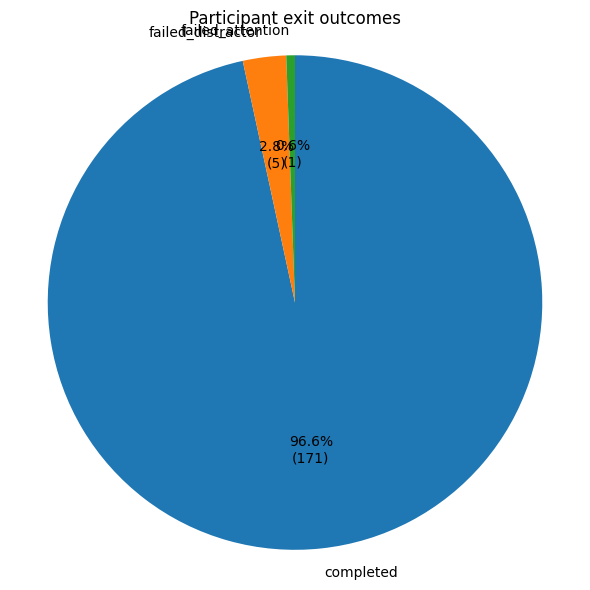

In [154]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    exit_counts,
    labels=exit_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100 * exit_counts.sum()))})",
    startangle=90,
    counterclock=False,
)
plt.title("Participant exit outcomes")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Failed by distractor colors

Number of failed trials: 8


PROLIFIC_PID   object variant_region  percent_colored  \
969    5e0f26b63ccda26295505f0d  rooster             FG              0.0   
1030   5e0f26b63ccda26295505f0d   square             FG             55.0   
7510   6784133089e3f78e0e08c94d  hexagon             FG             60.0   
7518   6784133089e3f78e0e08c94d    beets             BG             40.0   
16239  677743bf62e157794cf97ff4   square             FG             50.0   
16243  677743bf62e157794cf97ff4   celery             FG             40.0   
16834  60673bc6496cefa66a61e737     corn             FG             90.0   
16851  60673bc6496cefa66a61e737     boat             BG             20.0   

      target_color response_label  \
969          white           blue   
1030         brown           blue   
7510        purple         yellow   
7518         white            red   
16239         grey            red   
16243        brown           blue   
16834        green            red   
16851        white           blue   

                                              image_path  
969    color_images/gpt-4o/image_priors/rooster_3_c62...  
1030   shapes/shape_colored/square_v1_brown/FG_055_se...  
7510   shapes/shape_colored/hexagon_v0_purple/FG_060_...  
7518   color_images/gpt-4o/image_priors/beets_2_c2d24...  
16239  shapes/shape_colored/square_v0_grey/FG_050_seq...  
16243  color_images/gpt-4o/counterfact/celery_4_c500b...  
16834  color_images/gpt-4o/image_priors/corn_2_9ff217...  
16851  color_images/gpt-4o/image_priors/boat_2_a24f90...

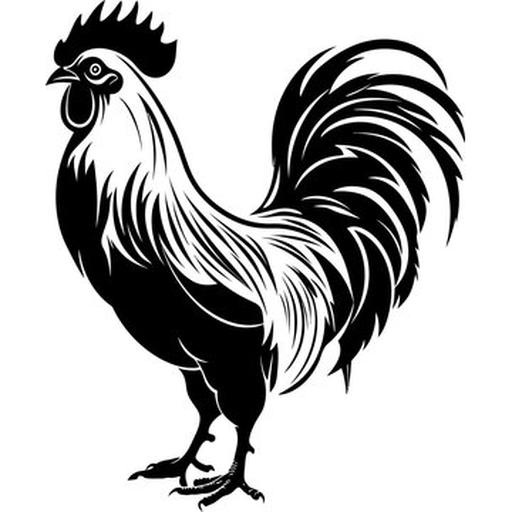

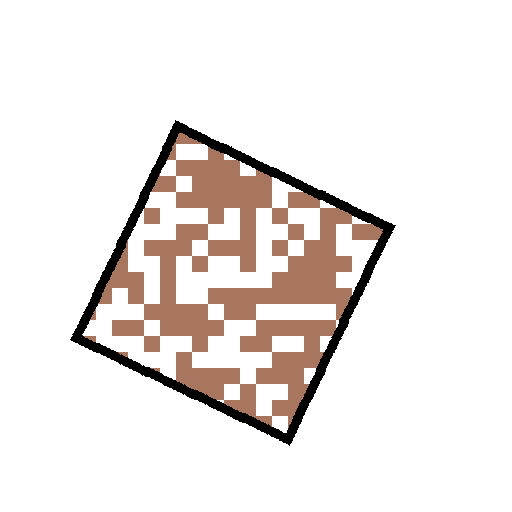

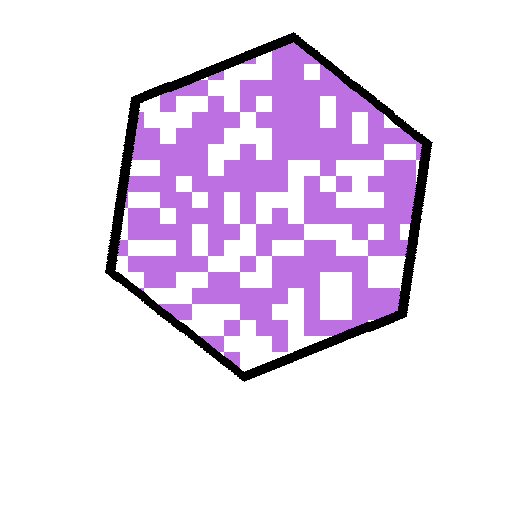

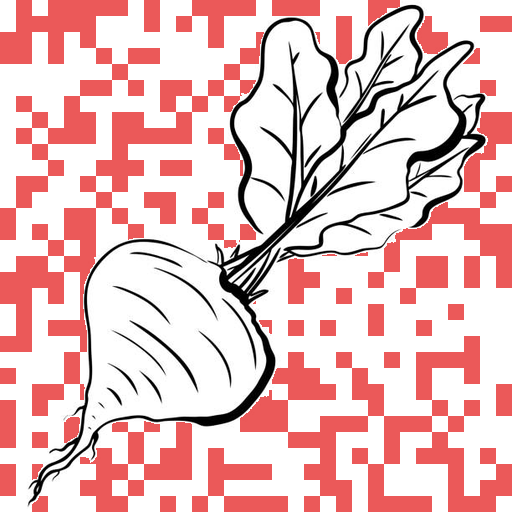

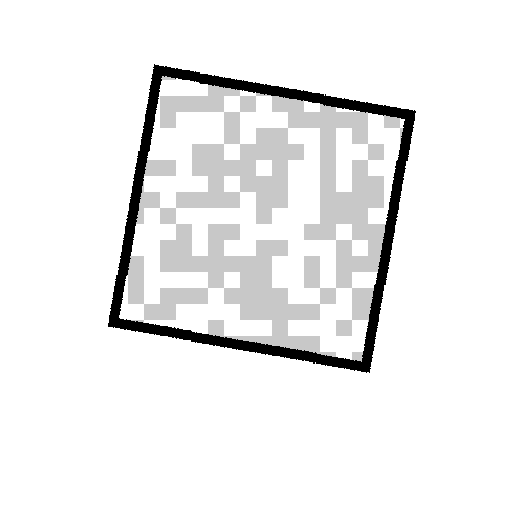

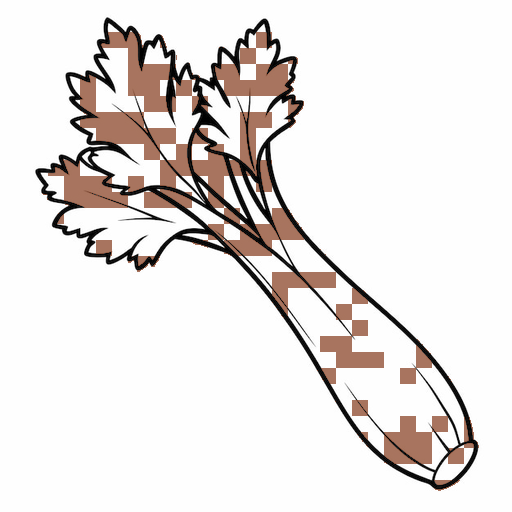

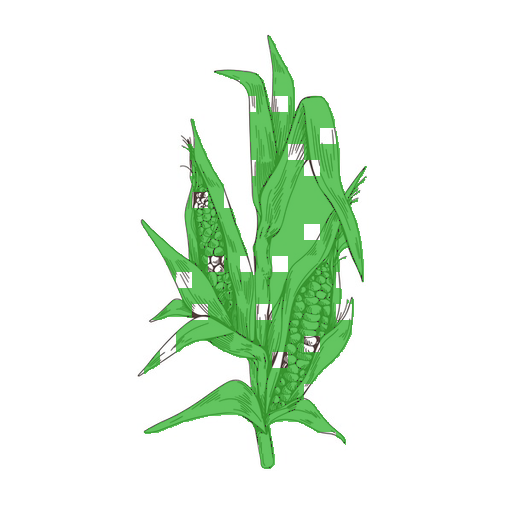

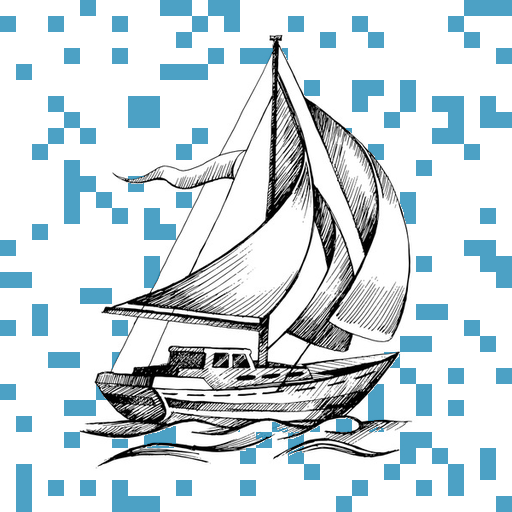

In [155]:
# Inpect failed distractor trials
df_failed = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "failed_distractor") &
    (df["target_color"] != df["response_label"]) &
    (df["response_label"] != "white")
].copy()

print(f"Number of failed trials: {len(df_failed)}")
display(df_failed[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_failed.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

## Succesfull completions

In [8]:
# Extract only valid color judgments for analysis)
df_complete = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed") 
].copy()

# Drop emtpy columns (those cary information for introspection or attention checks)
before = df_complete.shape[1]
df_complete = df_complete.dropna(axis=1, how="all")
after = df_complete.shape[1]

print(f"Dropped {before - after} empty columns")

len(df_complete)

NameError: name 'df' is not defined

In [157]:
image_counts = (
    df_complete[df_complete["exit_reason"] == "completed"]
    .groupby(["stimulus_type", "image_path"])
    .size()
    .reset_index(name="n_shown")
)
image_counts.sort_values("n_shown")


stimulus_type                                         image_path  \
2988          shape  shapes/shape_colored/triangle_v4_purple/FG_050...   
40    correct_prior  color_images/gpt-4o/image_priors/Komodo_dragon...   
1230  correct_prior  color_images/gpt-4o/image_priors/walrus_5_f062...   
1257  correct_prior  color_images/gpt-4o/image_priors/worm_1_69c913...   
1261    counterfact  color_images/gpt-4o/counterfact/Band_Aid_1_e73...   
...             ...                                                ...   
2081          shape  shapes/shape_colored/hexagon_v2_pink/FG_005_se...   
686   correct_prior  color_images/gpt-4o/image_priors/jack-o'-lante...   
2891          shape  shapes/shape_colored/triangle_v3_blue/FG_030_s...   
2280          shape  shapes/shape_colored/pentagon_v1_orange/FG_000...   
872   correct_prior  color_images/gpt-4o/image_priors/picket_fence_...   

      n_shown  
2988        2  
40          2  
1230        2  
1257        2  
1261        2  
...       ...  
2081       19  
686        20  
2891       20  
2280       20  
872        21  

[3003 rows x 3 columns]

In [158]:
df_raw[df_raw["exit_reason"] == "completed"]["profile_id"].value_counts()
print(df_raw["profile_id"].nunique())

print(df_complete[df_complete["exit_reason"] == "completed"]["image_path"].nunique())

69
3003


In [ ]:
extra_profiles = set(df_extra["profile_id"].astype(str))

fig, ax = plt.subplots(figsize=(14, 4))

x = range(len(profile_counts))
y = profile_counts.values

# main bars (unchanged)
ax.bar(x, y)

# overlay markers for profiles that appear in df_extra
highlight_x = [
    i for i, pid in enumerate(profile_counts.index)
    if pid in extra_profiles
]
highlight_y = [y[i] for i in highlight_x]

ax.scatter(
    highlight_x,
    highlight_y,
    color="red",
    zorder=3,
    label="Also in df_extra"
)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile")

step = 5
ax.set_xticks(range(0, len(profile_counts), step))
ax.set_xticklabels(range(0, len(profile_counts), step))

ax.legend()
plt.show()


profile_id
profile_23_last     6
profile_34_last     6
profile_20_last     5
profile_17_last     5
profile_7_first     5
                   ..
profile_12_last     1
profile_35_first    1
profile_18_last     1
profile_32_first    1
profile_14_first    1
Name: count, Length: 69, dtype: int64


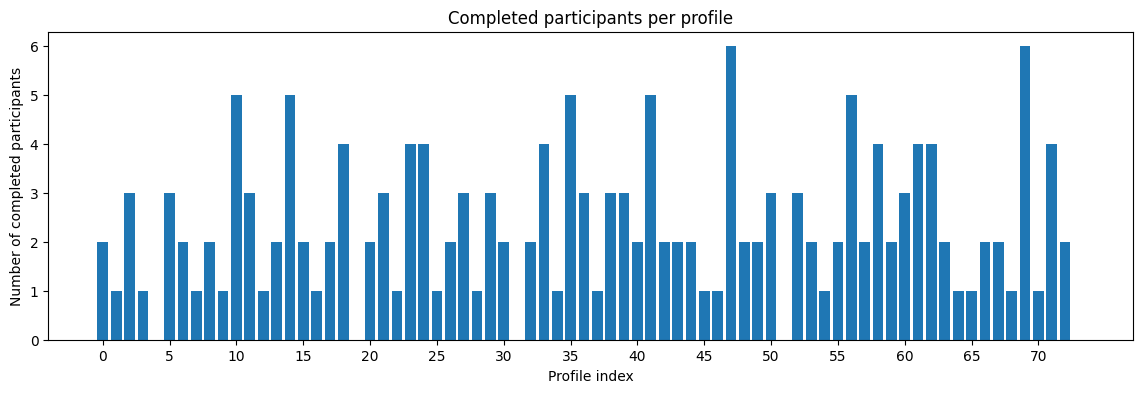

In [159]:
N_PROFILES = 37
intro_positions = ["first", "last"]

all_profiles = [
    f"profile_{i}_{pos}"
    for i in range(N_PROFILES)
    for pos in intro_positions
]

completed = df_raw[df_raw["exit_reason"] == "completed"]

profile_counts = (
    completed["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)
print(df_raw[df_raw["exit_reason"] == "completed"]["profile_id"].value_counts())

fig, ax = plt.subplots(figsize=(14, 4))

ax.bar(range(len(profile_counts)), profile_counts.values)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile")

step = 5  # show every 5th profile
ax.set_xticks(range(0, len(profile_counts), step))
ax.set_xticklabels(range(0, len(profile_counts), step))

plt.show()


Number of warnings (wrong responses): 30


PROLIFIC_PID                    object variant_region  \
429    6658b32dd8c3da854c842802         great white shark             FG   
1146   63f77a5dde1ea03305e119e0                 cockroach             FG   
1519   5f25e860dd98342ce97e7403                     camel             FG   
1865   67680e24c4684ebbc6ec8af3                    circle             BG   
3120   574da26c7f1e770007f42d11            frilled lizard             FG   
4357   6978c580d801e64f18d9e3ab                   giraffe             FG   
4541   58f669cefb4d7500014af69b                  gas pump             FG   
4997   673f6ffebce20832346325de                  keyboard             FG   
5120   5bf1c9d332cb3b0001f6f1c3                   hexagon             FG   
5245   62cbfe7dd820cc9d2cd7c87a                  gas pump             FG   
5360   62fb8e94ce94179d6a4e8277                  sea lion             FG   
6113   65bfa2967c731d263eb29732                     koala             FG   
6807   61fa9062d42cb19beec49109               waffle iron             FG   
7174   610772789d0d3082cb3274c6                  tricycle             BG   
8656   5c5346b553fba80001bc9662            sewing machine             FG   
9032   62ed458d61ebd1930833e95a          sealyham terrier             FG   
9882   614e5092e08a3a2d3204ffd2                    square             FG   
9996   63076cd447ae6e2366804685            frilled lizard             FG   
10191  6745f46c86b3a0d19cd1d4b7                   hexagon             FG   
11412  60fddfafefa723957aa5a45b                  triangle             FG   
11563  5e6ce118673e50000c303890                   hexagon             FG   
12142  5eeb58ec4c86582a76ff55ec              cheeseburger             FG   
12413  5acd0749a3ba7a0001b50834                      tuba             FG   
13006  637e4351f6c7592941500be6     flat-coated retriever             BG   
13418  5c5ff87f8c0552000109d7de        christmas stocking             BG   
14521  59fc2094087f2e0001ead5fa                  pentagon             FG   
15564  6667015e358c1fe41b8a3d7f                      moth             FG   
17289  682cd328bd53185cbbb59840  chesapeake bay retriever             FG   
17827  5a9ac3061eda410001366658                   hexagon             FG   
18391  665ee374604d2c5d4d858efd                   hexagon             FG   

       percent_colored target_color response_label  \
429                0.0        white           blue   
1146              55.0        brown           blue   
1519               5.0        brown           blue   
1865              40.0        white            red   
3120               0.0        white           blue   
4357              70.0        brown           blue   
4541              10.0          red          green   
4997              30.0        brown           blue   
5120              30.0         pink          green   
5245              70.0          red          green   
5360              50.0        brown           blue   
6113               5.0         pink          green   
6807              30.0          red          green   
7174              40.0        white           blue   
8656              80.0        brown           blue   
9032              60.0       purple         yellow   
9882               5.0       orange           blue   
9996             100.0        brown           blue   
10191             20.0          red          green   
11412             50.0        brown           blue   
11563              0.0        white           blue   
12142             50.0        brown           blue   
12413             20.0          red          green   
13006             80.0        white           blue   
13418             60.0        white            red   
14521              0.0        white            red   
15564             55.0        brown           blue   
17289              5.0        green            red   
17827             80.0        brown           blue   
18391             10.0       purple       

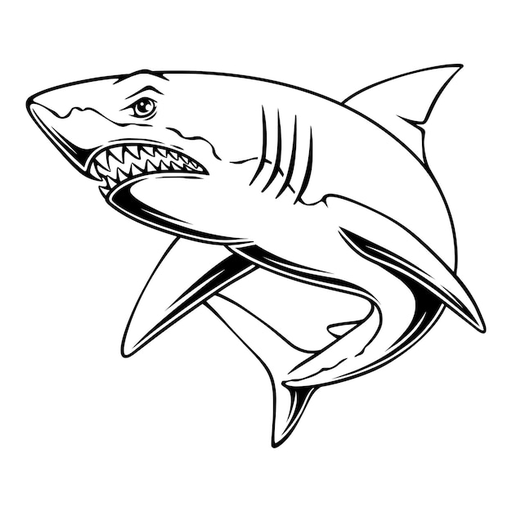

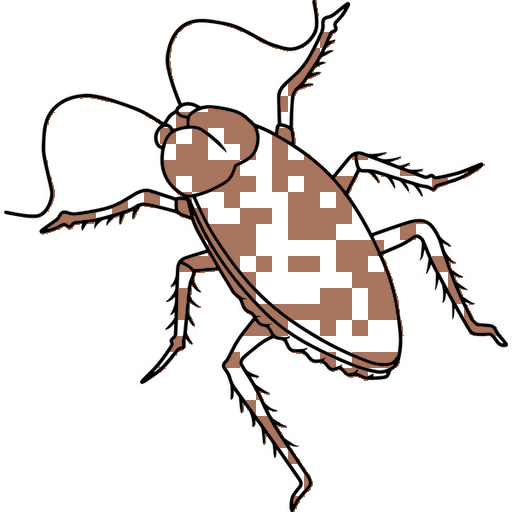

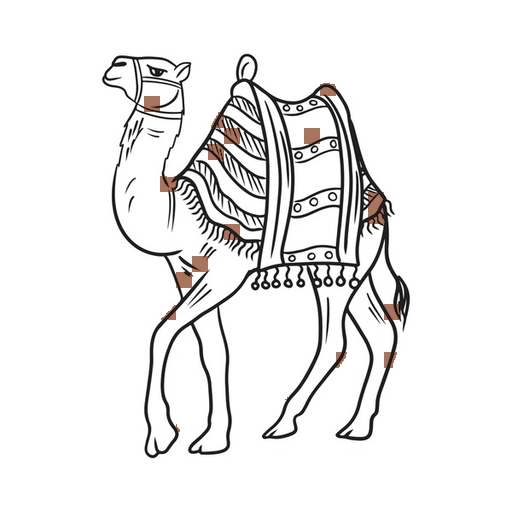

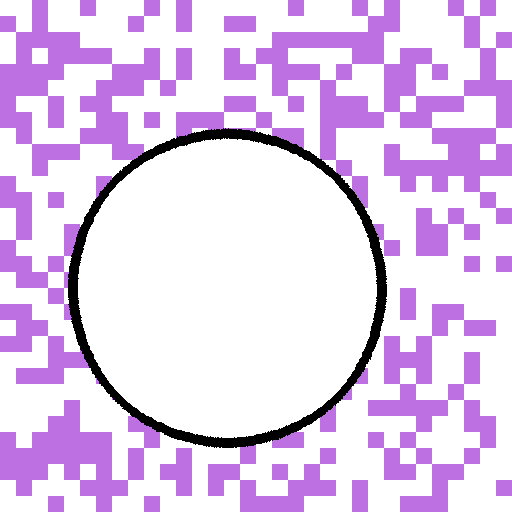

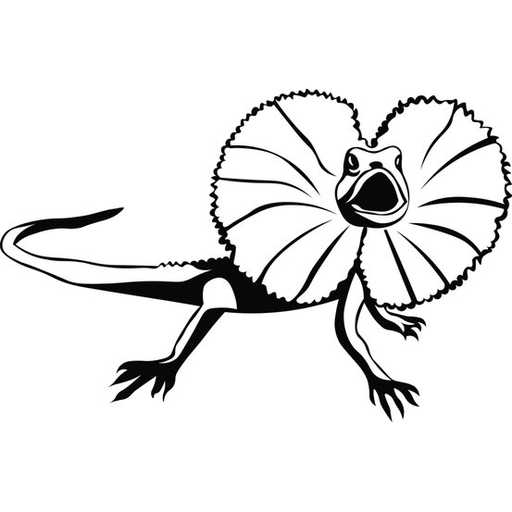

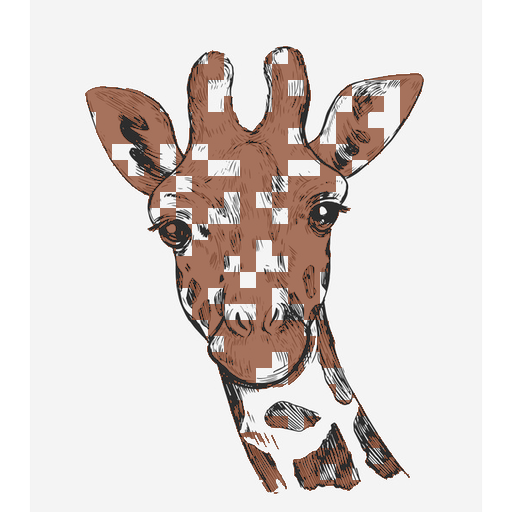

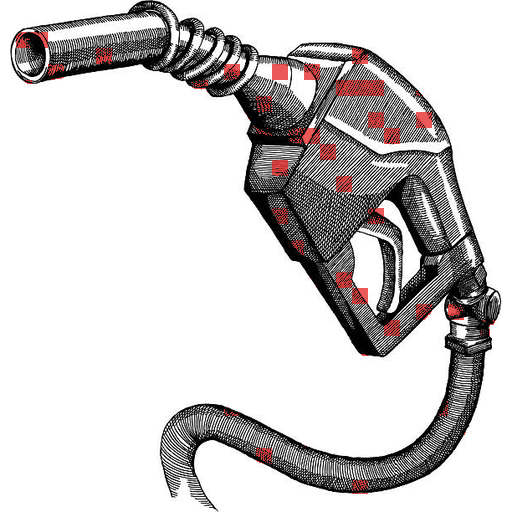

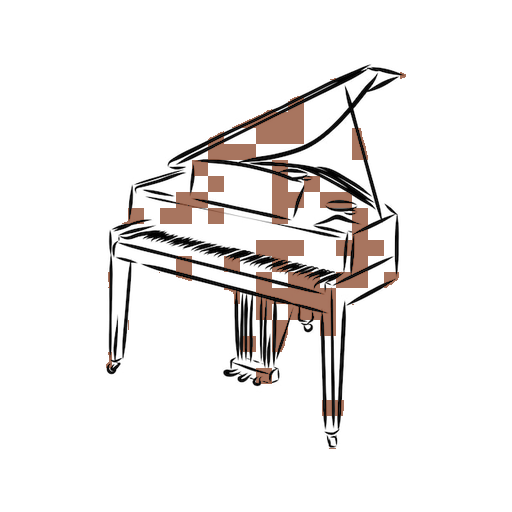

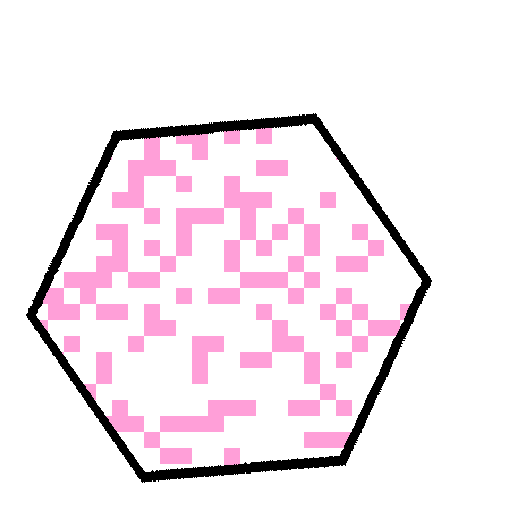

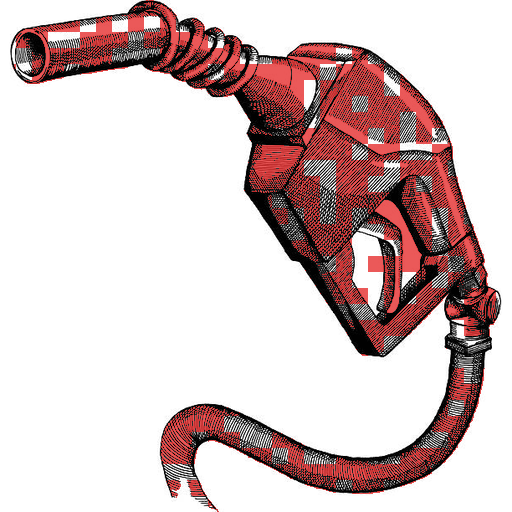

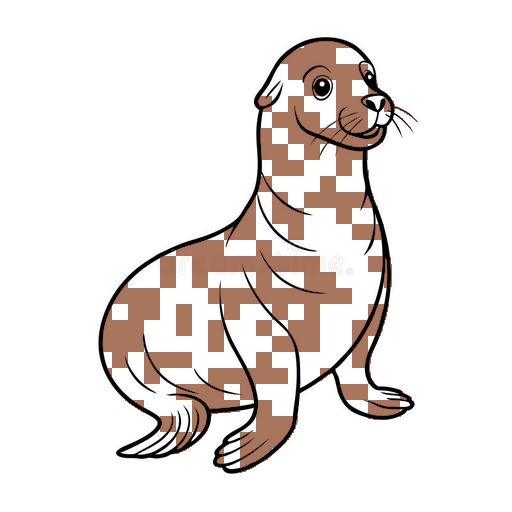

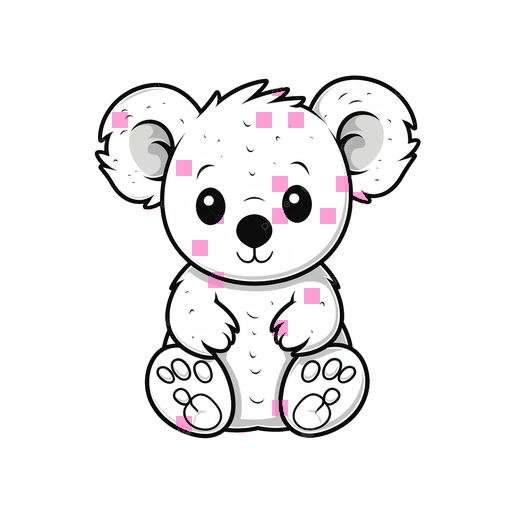

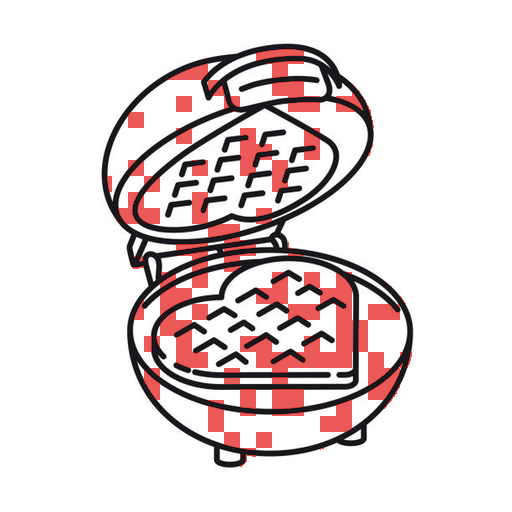

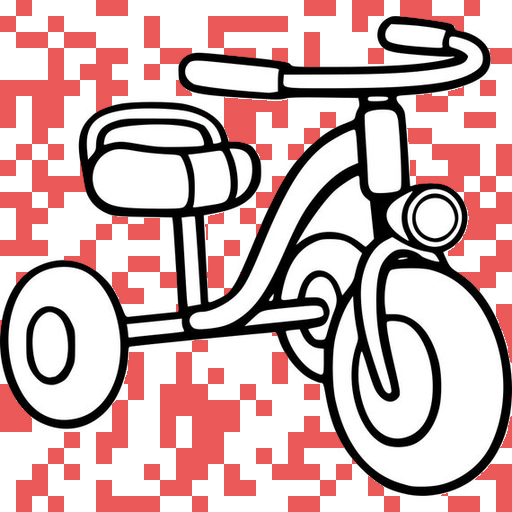

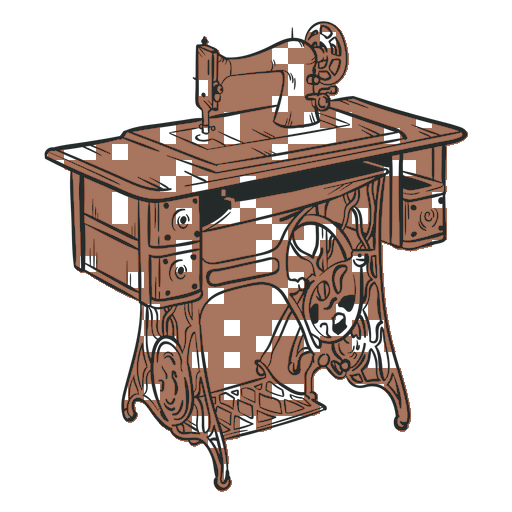

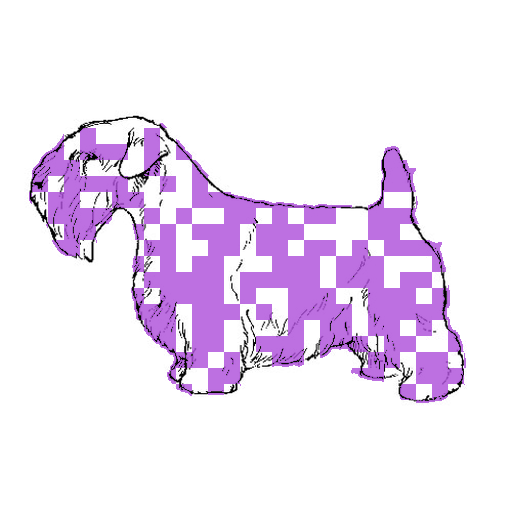

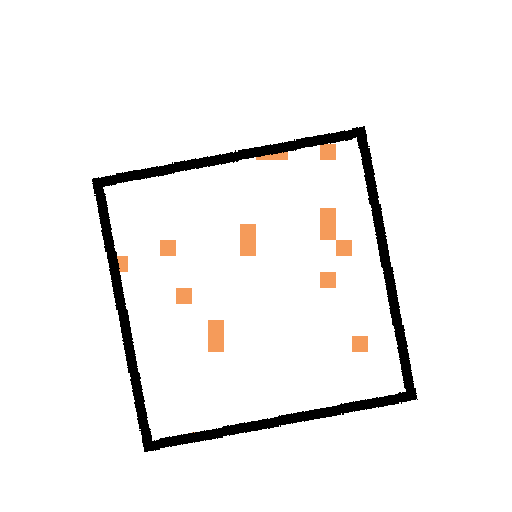

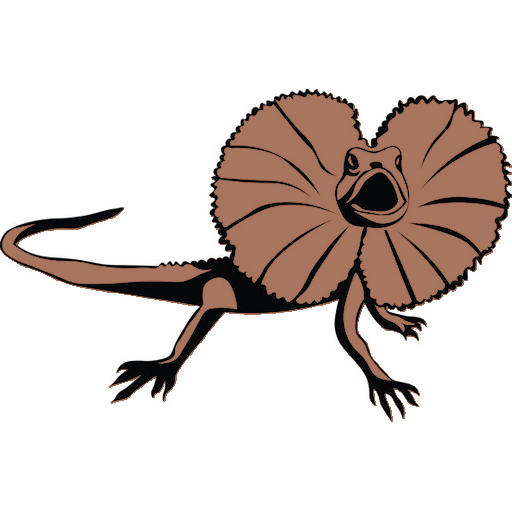

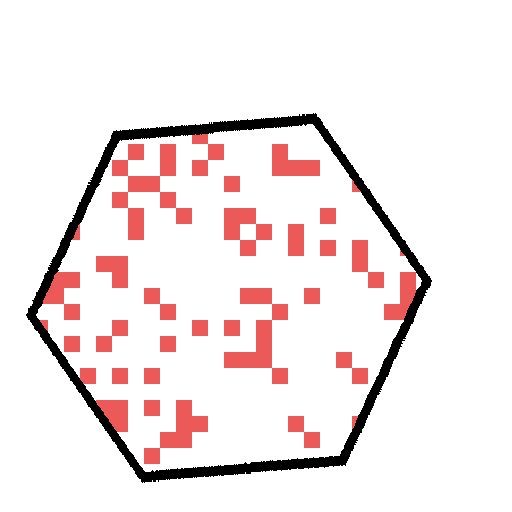

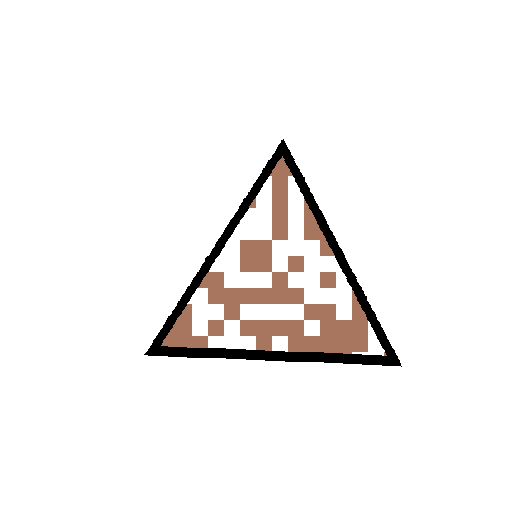

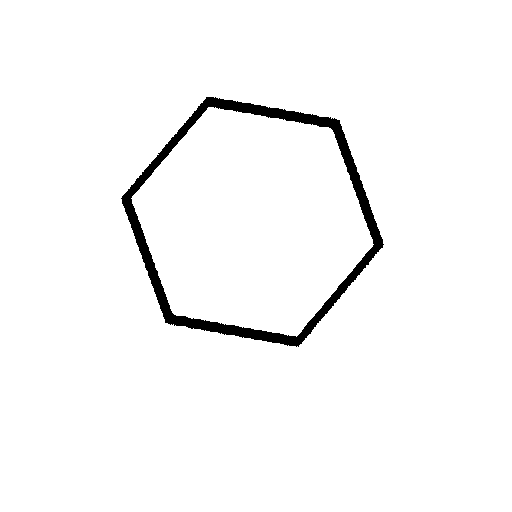

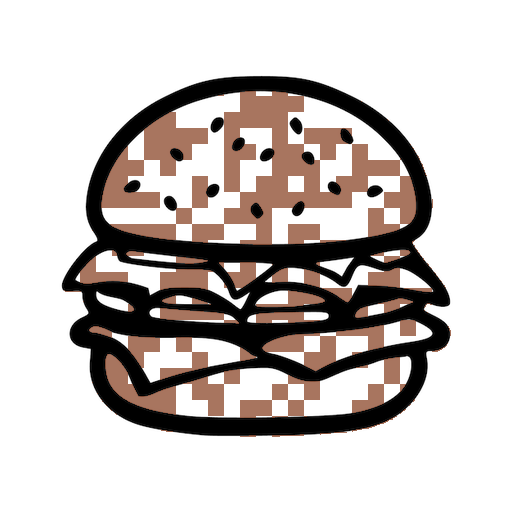

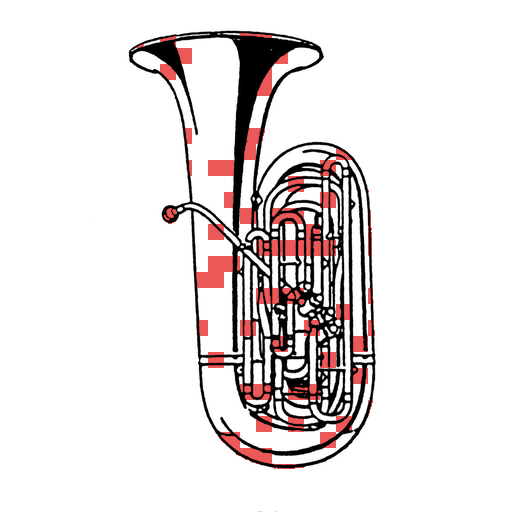

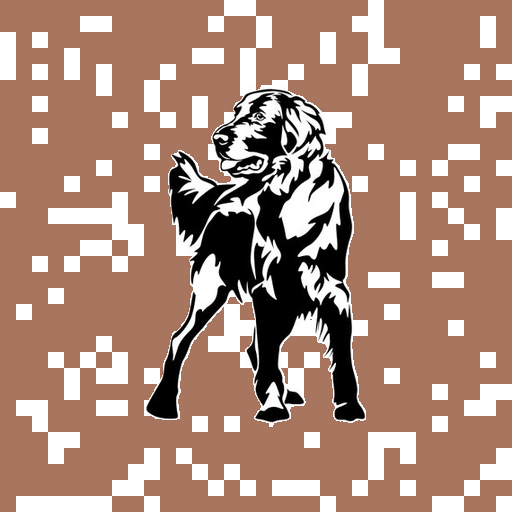

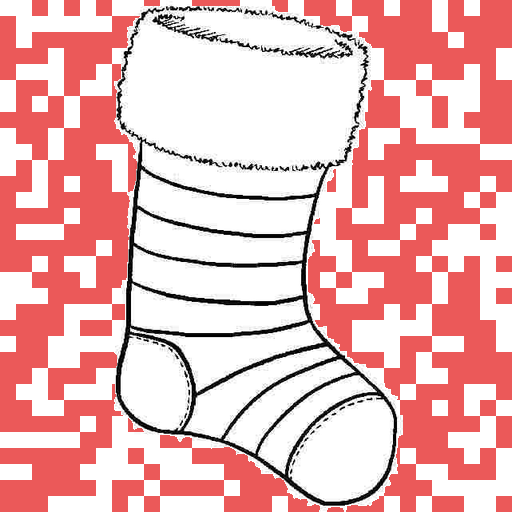

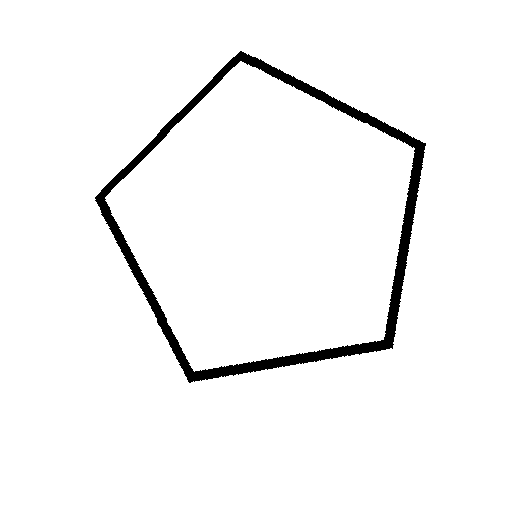

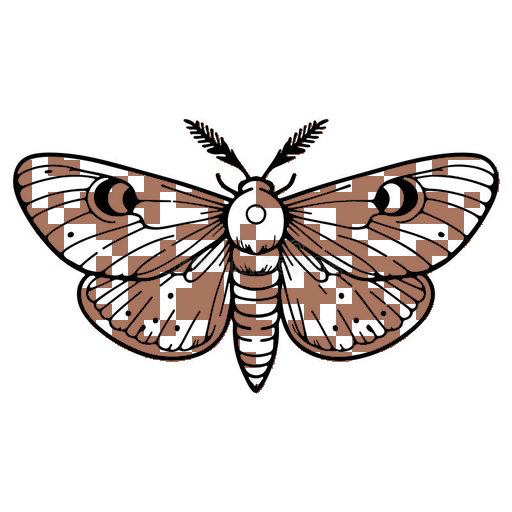

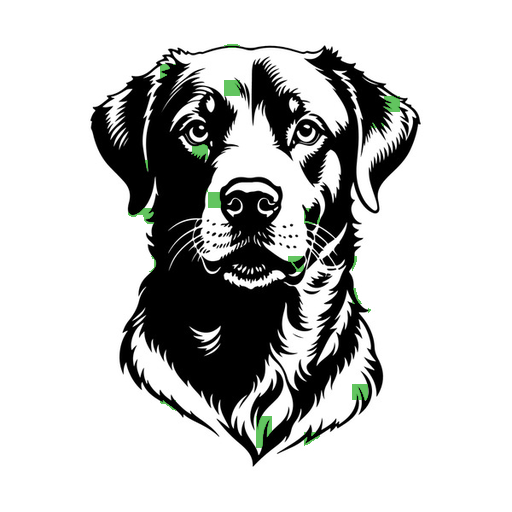

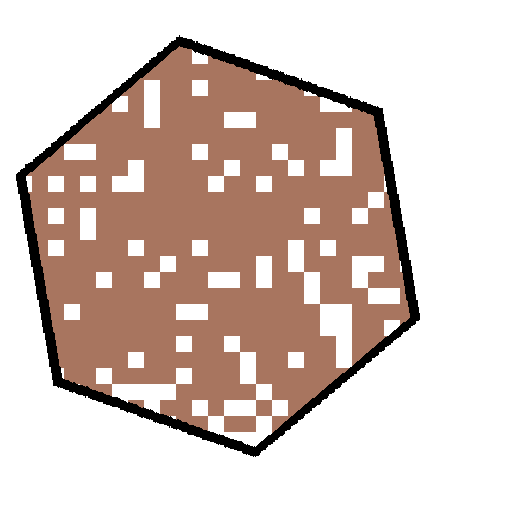

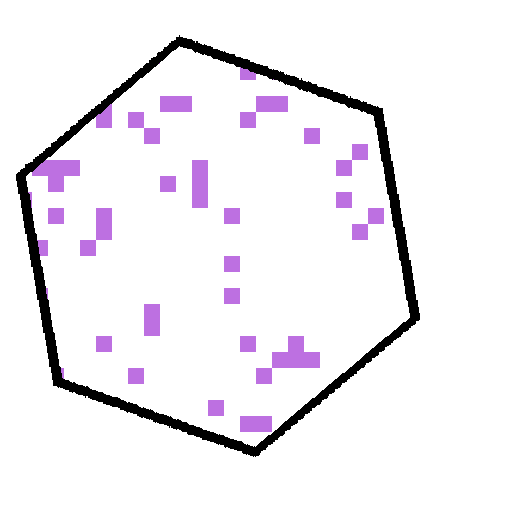

In [160]:
# Warnings
df_warnings = df_complete[(df_complete["target_color"] != df_complete["response_label"]) &
            (df_complete["response_label"] != "white")]

print(f"Number of warnings (wrong responses): {len(df_warnings)}")
display(df_warnings[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_warnings.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

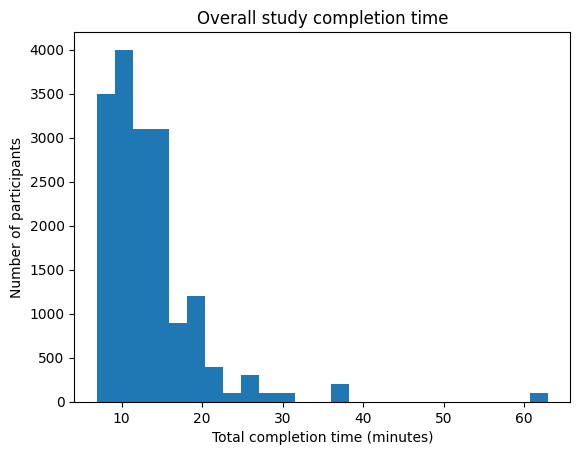

In [161]:
# Participant-level completion time (minutes) 
df_complete['experiment_start_time'] = pd.to_datetime(
    df_complete['experiment_start_time'], unit='ms'
)
df_complete['exit_time'] = pd.to_datetime(
    df_complete['exit_time'], unit='ms'
)

df_complete['total_time_min'] = (
    df_complete['exit_time'] - df_complete['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_complete['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Accuracy vs. coloring fraction

In [162]:
# Accuracy: response must match target_color
df_complete.loc[df_complete["variant_region"] == "BG", "target_color"] = "white" # Fix wrong labels for BG, will be fixed in future study runs
df_complete["accuracy"] = (df_complete["response_label"] == df_complete["target_color"]).astype(float)
df_complete["accuracy"].mean()

np.float64(0.7629824561403509)

In [163]:
grouped = df_complete.groupby(["variant_region", "percent_colored"])

summary = grouped["accuracy"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# Optional: 95% CI
summary["ci"] = (
    stats.t.ppf(0.975, summary["n"] - 1)
    * (summary["std"] / np.sqrt(summary["n"]))
)


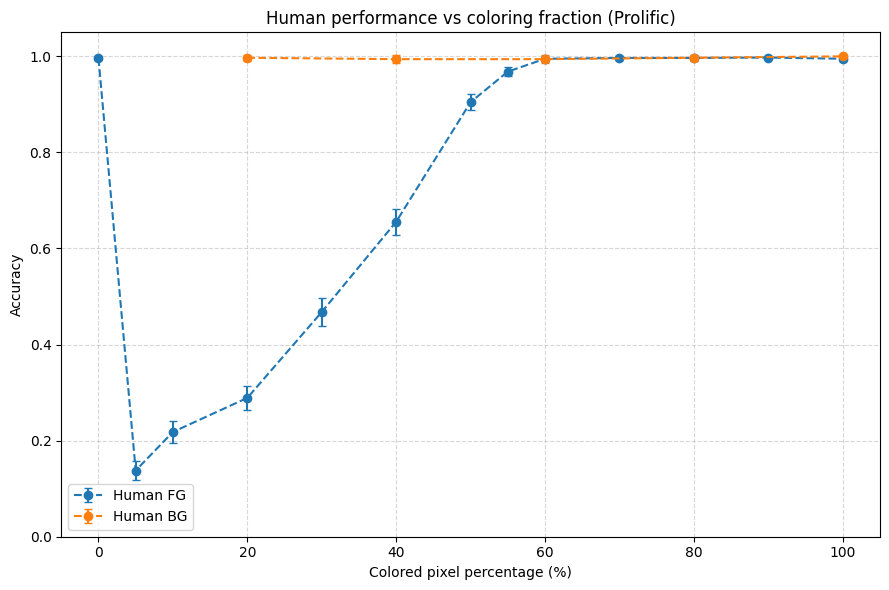

In [164]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = summary[summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o--",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Human performance vs coloring fraction (Prolific)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


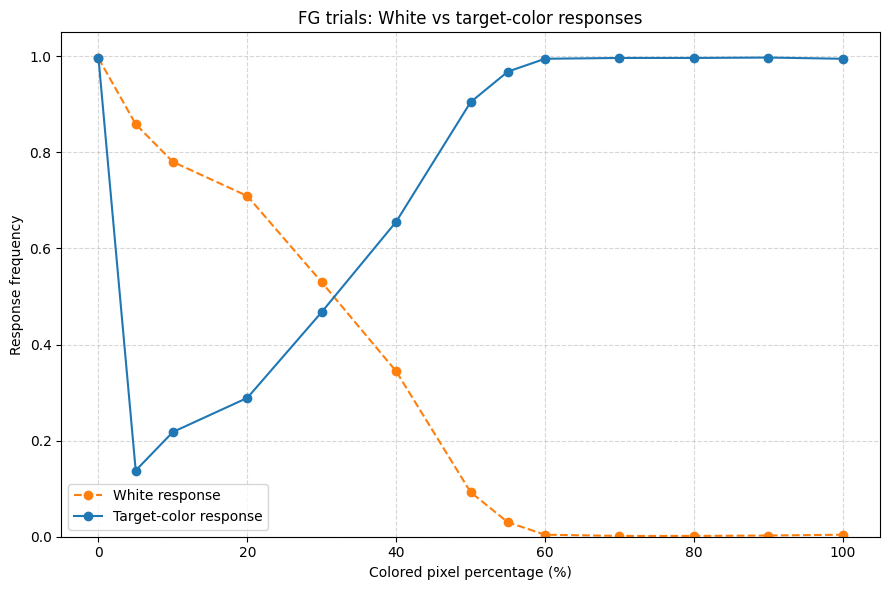

In [165]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

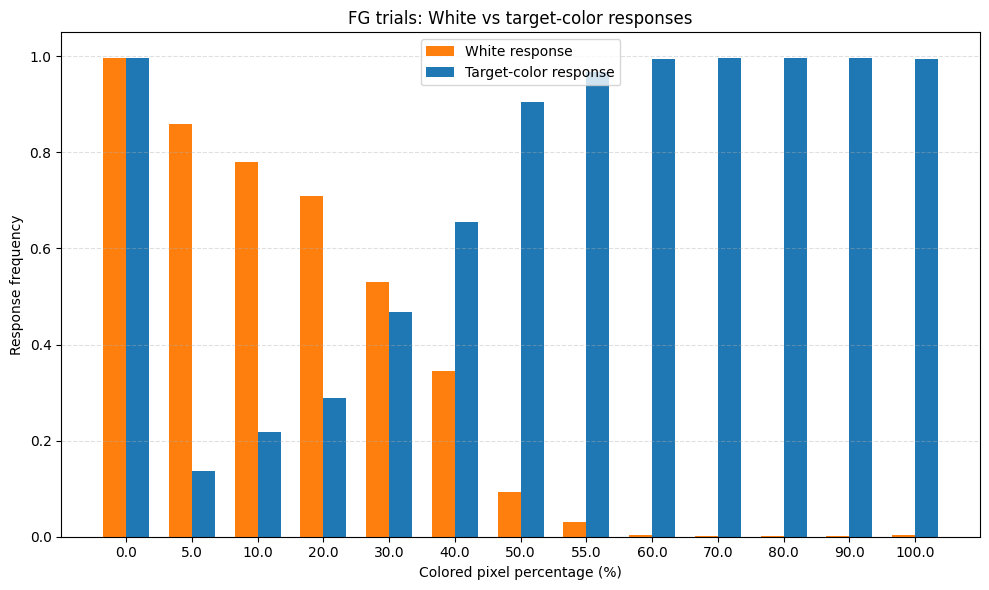

In [166]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


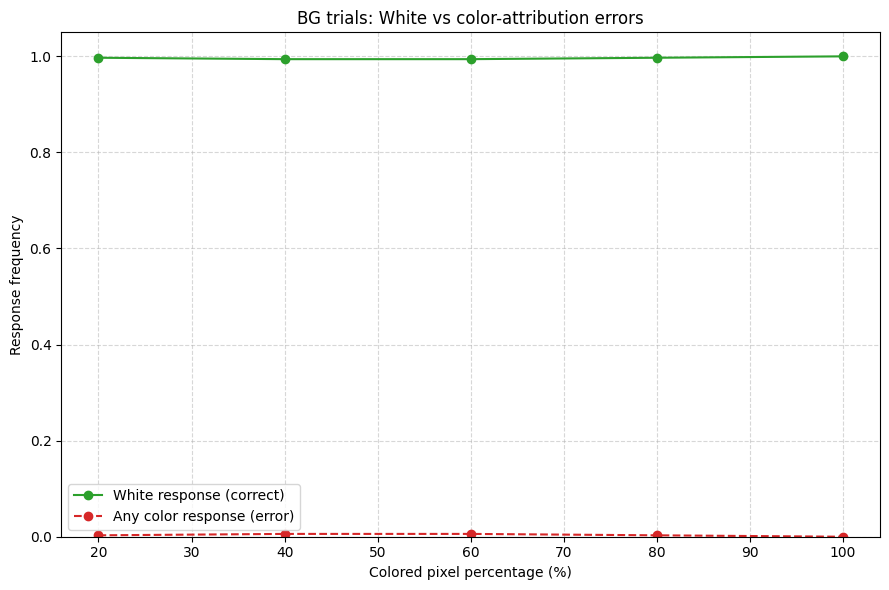

In [167]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

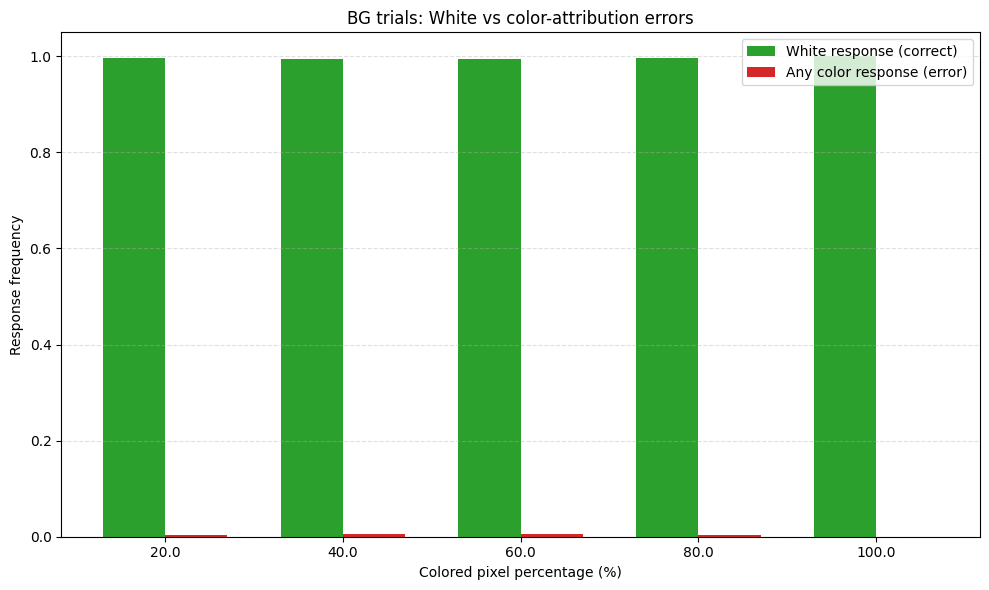

In [168]:
x = np.arange(len(bg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    bg_summary["p_white"],
    width,
    label="White response (correct)",
    color="#2ca02c",
)

ax.bar(
    x + width / 2,
    bg_summary["p_colored"],
    width,
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xticks(x)
ax.set_xticklabels(bg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Certainty vs. coloring fraction

In [169]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(["variant_region", "percent_colored"])
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat([initial_summary, final_summary], ignore_index=True)

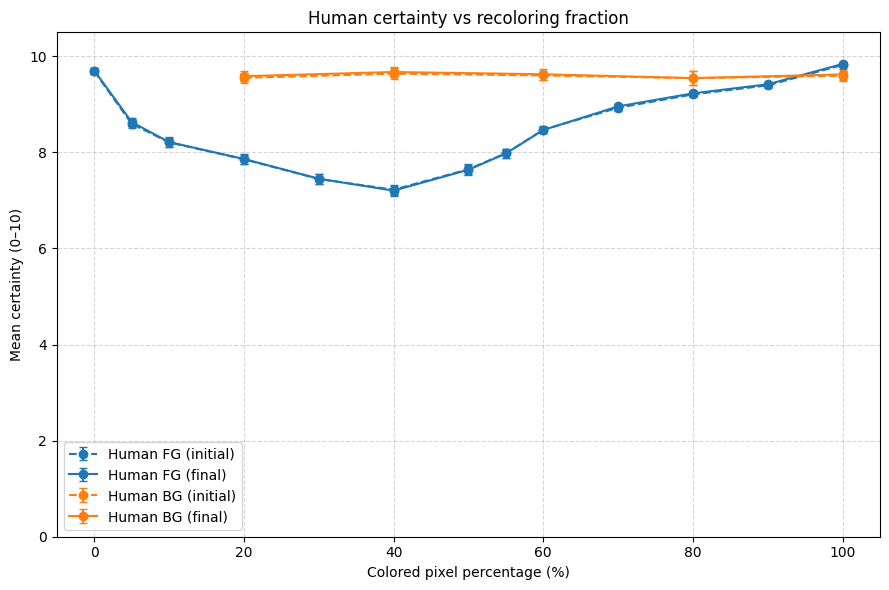

In [170]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "Human FG (initial)",
    ("FG", "final_certainty"): "Human FG (final)",
    ("BG", "initial_certainty"): "Human BG (initial)",
    ("BG", "final_certainty"): "Human BG (final)",
}

for region in ["FG", "BG"]:
    for cert_type in ["initial_certainty", "final_certainty"]:
        sub = cert_summary[
            (cert_summary["variant_region"] == region) &
            (cert_summary["certainty_type"] == cert_type)
        ]

        if sub.empty:
            continue

        ax.errorbar(
            sub["percent_colored"],
            sub["mean"],
            yerr=sub["ci"],
            fmt="o",
            linestyle=linestyles[cert_type],
            color=colors[region],
            capsize=3,
            label=labels[(region, cert_type)],
        )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Mean certainty (0–10)")
ax.set_ylim(0, 10.5)
ax.set_title("Human certainty vs recoloring fraction")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Response times

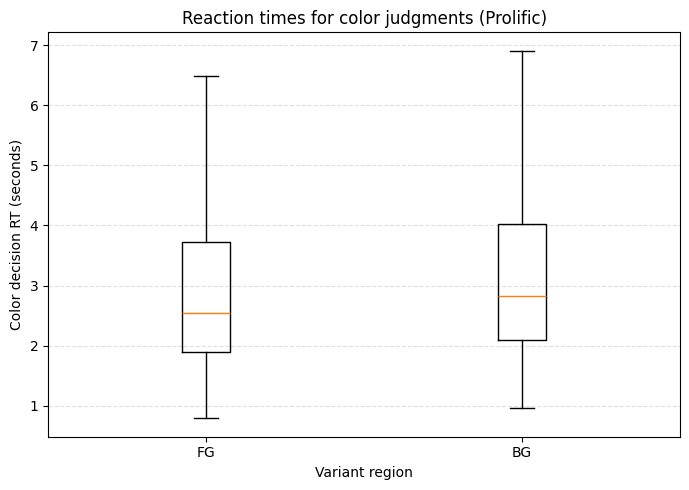

In [171]:
df_rt = df_complete.copy()

# ms → seconds
df_rt["color_time"] = df_rt["color_time"] / 1000

# keep valid RTs only
df_color_rt = df_rt[
    df_rt["color_time"].notna() &
    (df_rt["color_time"] > 0)
]

groups = [
    df_color_rt.loc[df_color_rt["variant_region"] == "FG", "color_time"].values,
    df_color_rt.loc[df_color_rt["variant_region"] == "BG", "color_time"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(
    groups,
    tick_labels=["FG", "BG"],
    showfliers=False,
)

plt.xlabel("Variant region")
plt.ylabel("Color decision RT (seconds)")
plt.title("Reaction times for color judgments (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [172]:
df_rt["final_certainty_time"] = df_rt["second_certainty_time"].fillna(
    df_rt["first_certainty_time"]
)

df_rt["rt_certainty_tot_sec"] = (
    (df_rt["final_certainty_time"] - df_rt["color_time"]) / 1000
)

df_rt = df_rt[
    df_rt["rt_certainty_tot_sec"].notna() &
    (df_rt["rt_certainty_tot_sec"] > 0)
]

df_rt["rt_certainty_revision_sec"] = (
    (df_rt["second_certainty_time"] - df_rt["first_certainty_time"]) / 1000
)

df_revision = df_rt[
    df_rt["rt_certainty_revision_sec"].notna() &
    (df_rt["rt_certainty_revision_sec"] > 0)
]

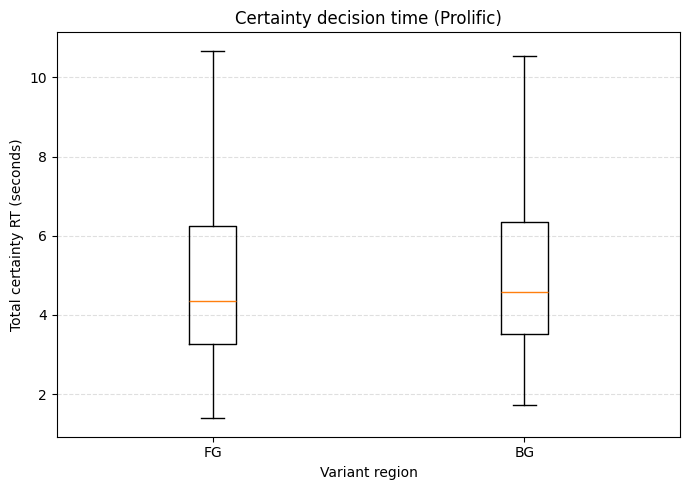

In [173]:
groups = [
    df_rt[df_rt["variant_region"] == "FG"]["rt_certainty_tot_sec"].values,
    df_rt[df_rt["variant_region"] == "BG"]["rt_certainty_tot_sec"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(groups, tick_labels=["FG", "BG"], showfliers=False)
plt.xlabel("Variant region")
plt.ylabel("Total certainty RT (seconds)")
plt.title("Certainty decision time (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [174]:
rev_rate = (
    df_complete["second_certainty_time"].notna()
    .groupby(df_complete["variant_region"])
    .mean()
)

print(rev_rate)

variant_region
BG    0.035088
FG    0.055231
Name: second_certainty_time, dtype: float64


## Introspection question

In [175]:
df[df["task_type"] == "introspection"][["intro_position","response", "slider_start"]]


intro_position response  slider_start
106             last       78          50.0
108            first       73          50.0
320             last       51          50.0
427             last       72          50.0
535             last       55          50.0
...              ...      ...           ...
18139          first       70          50.0
18351           last       65          50.0
18353          first       95          50.0
18566           last       60          50.0
18568          first       65          50.0

[175 rows x 3 columns]

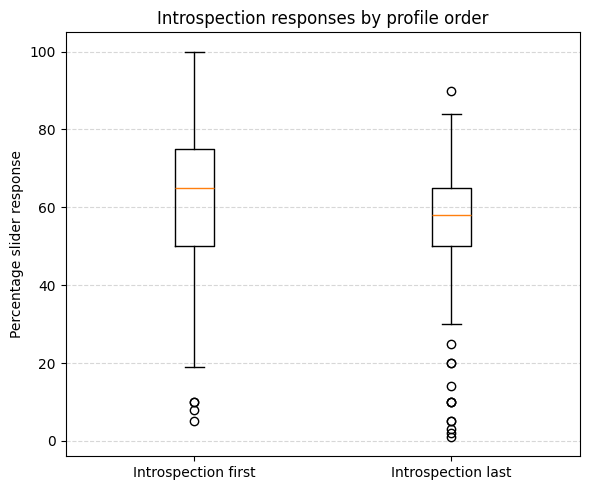

In [176]:
# Keep only introspection trials
df_intro = df[
    (df["task_type"] == "introspection") &
    (df["intro_position"].isin(["first", "last"]))
].copy()

groups = [
    df_intro[df_intro["intro_position"] == "first"]["response"].dropna(),
    df_intro[df_intro["intro_position"] == "last"]["response"].dropna(),
]

plt.figure(figsize=(6, 5))
plt.boxplot(
    groups,
    tick_labels=["Introspection first", "Introspection last"],
    showfliers=True,
)

plt.ylabel("Percentage slider response")
plt.title("Introspection responses by profile order")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

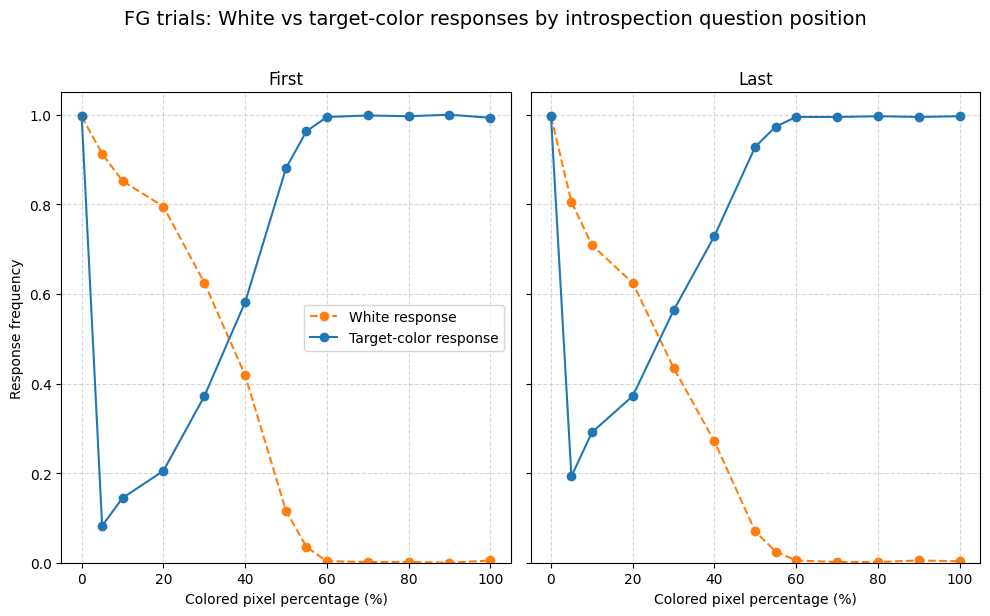

In [177]:
df_fg = df_complete[
    (df_complete["variant_region"] == "FG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by introspection question position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_fg[df_fg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


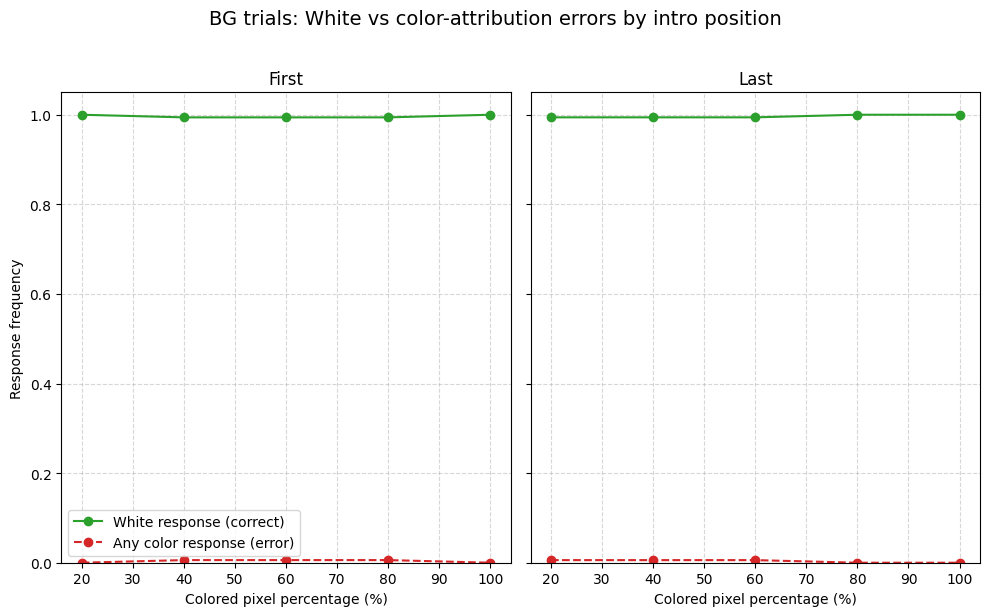

In [178]:
df_bg = df_complete[
    (df_complete["variant_region"] == "BG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_bg[df_bg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()

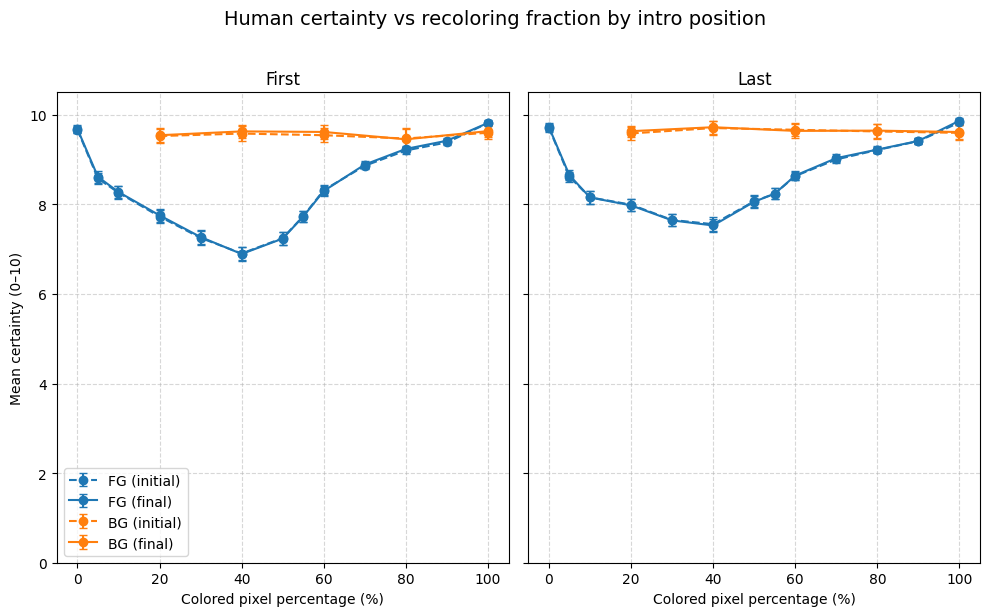

In [179]:
df_cert = df_complete[
    df_complete["intro_position"].isin(["first", "last"])
].copy()

df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["intro_position", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

cert_summary = pd.concat(
    [
        summarize_certainty(df_cert, "initial_certainty"),
        summarize_certainty(df_cert, "final_certainty"),
    ],
    ignore_index=True
)

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs recoloring fraction by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

colors = {"FG": "#1f77b4", "BG": "#ff7f0e"}
linestyles = {"initial_certainty": "--", "final_certainty": "-"}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, pos in zip(axes, intro_positions):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["intro_position"] == pos) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()


## Split by stimulus type

In [180]:
df_complete.stimulus_type.value_counts()

stimulus_type
correct_prior    7524
shape            7524
counterfact      2052
Name: count, dtype: int64

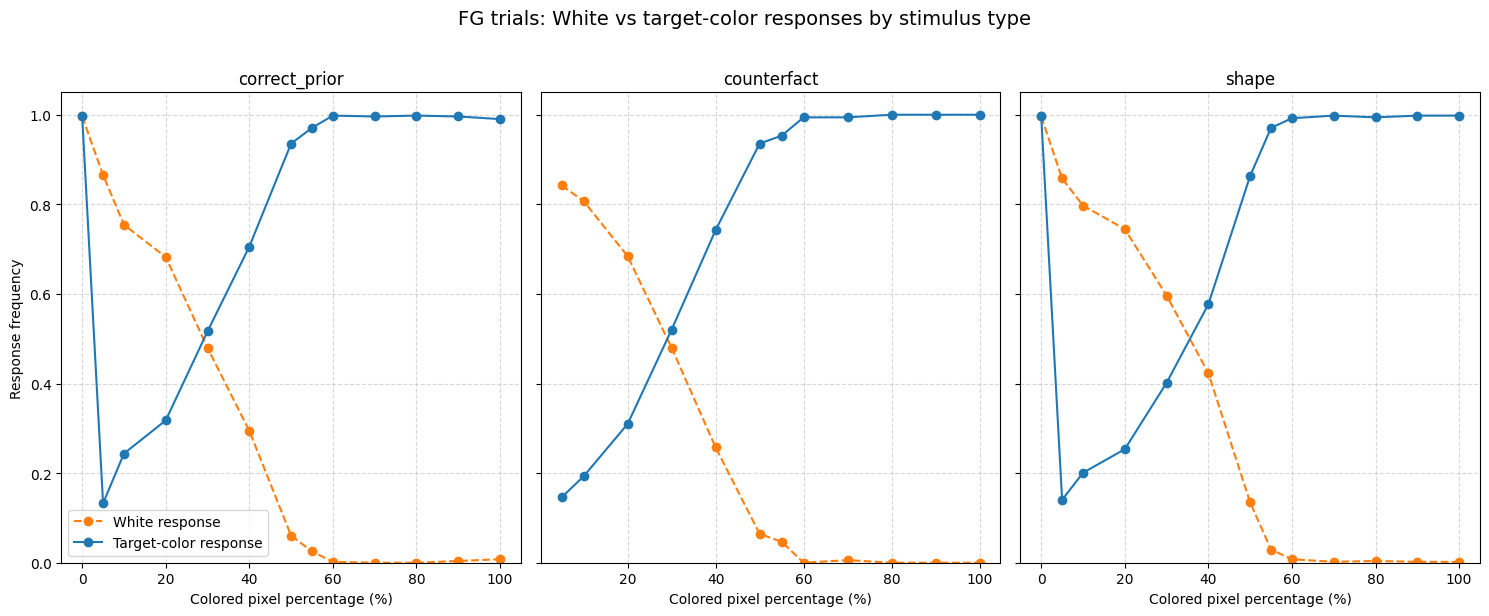

In [181]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

stimulus_types = sorted(df_fg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_fg[df_fg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


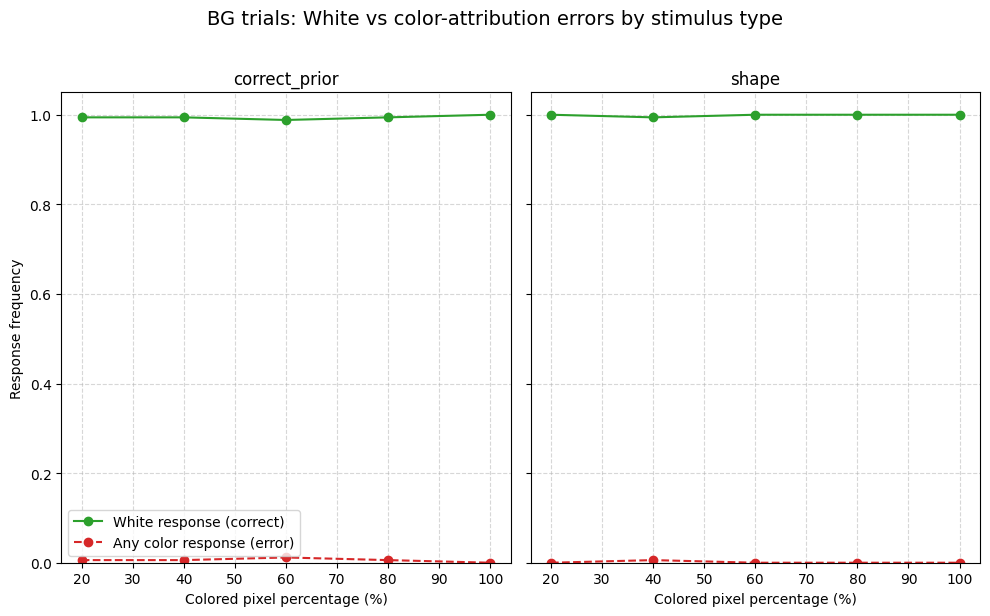

In [182]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

stimulus_types = sorted(df_bg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_bg[df_bg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


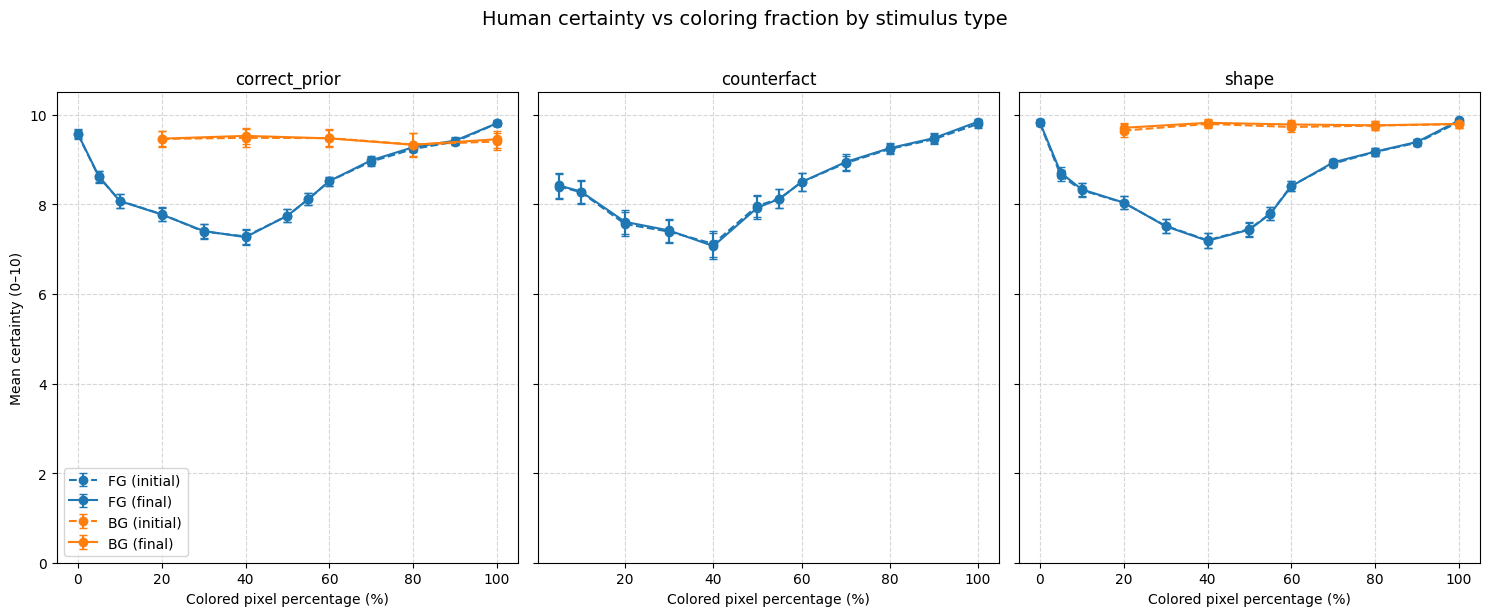

In [183]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["stimulus_type", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat(
    [initial_summary, final_summary],
    ignore_index=True
)

stimulus_types = sorted(df_cert["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs coloring fraction by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, stim in zip(axes, stimulus_types):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["stimulus_type"] == stim) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()